In [1]:
!pip install -q --upgrade bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install datasets
!pip install torch
!pip install evaluate
! pip install -U datasets huggingface-hub

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 92.6/92.6 MB 9.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 294.8/294.8 kB 4.8 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7.8/7.8 MB 12.1 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1.3/1.3 MB 14.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚

In [2]:
import pandas as pd
import re
import transformers
print(transformers.__version__)
import huggingface_hub
from transformers import AutoTokenizer, AutoConfig
from transformers import AutoModelForCausalLM
from transformers import  Trainer, TrainingArguments
from accelerate import init_empty_weights,infer_auto_device_map
import torch
import evaluate
import torch
import numpy as np

4.34.0.dev0


In [40]:
from datasets import load_dataset

dataset = load_dataset("anujsahani01/Custom_Dataset_CodeGen")

In [41]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text_prompt', 'code_prompt'],
        num_rows: 178487
    })
    validation: Dataset({
        features: ['text_prompt', 'code_prompt'],
        num_rows: 59496
    })
    test: Dataset({
        features: ['text_prompt', 'code_prompt'],
        num_rows: 59496
    })
})

In [5]:
train_prompts = dataset['train']['text_prompt']
test_prompts = dataset['test']['text_prompt']
validation_prompts = dataset['validation']['text_prompt']

train_code = dataset['train']['code_prompt']
test_code = dataset['test']['code_prompt']
validation_code = dataset['validation']['code_prompt']

print(len(train_prompts) == len(train_code))
print(len(test_prompts) == len(test_code))
print(len(validation_prompts) == len(validation_code))
print('----------------------------------------------')
print(None in train_prompts)
print(None in test_prompts)
print(None in validation_prompts)
print(None in train_code)
print(None in test_code)
print(None in validation_code)

True
True
True
----------------------------------------------
False
False
True
True
False
True


In [6]:
train_prompts = dataset['train']['text_prompt']
test_prompts = dataset['test']['text_prompt']
validation_prompts = dataset['validation']['text_prompt']

train_code = dataset['train']['code_prompt']
test_code = dataset['test']['code_prompt']
validation_code = dataset['validation']['code_prompt']

final_train_prompts = []
final_test_prompts = []
final_validation_prompts = []

final_train_code = []
final_test_code = []
final_validation_code = []

if None in train_prompts or None in train_code:
    for i in range(len(train_prompts)):
        if train_prompts[i] is not None and train_code[i] is not None:
            final_train_prompts.append(train_prompts[i])
            final_train_code.append(train_code[i])
else:
    final_train_prompts = train_prompts
    final_train_code = train_code

if None in test_prompts or None in test_code:
    for i in range(len(test_prompts)):
        if test_prompts[i] is not None and test_code[i] is not None:
            final_test_prompts.append(test_prompts[i])
            final_test_code.append(test_code[i])
else:
    final_test_prompts = test_prompts
    final_test_code = test_code

if None in validation_prompts or None in validation_code:
    for i in range(len(validation_prompts)):
        if validation_prompts[i] is not None and validation_code[i] is not None:
            final_validation_prompts.append(validation_prompts[i])
            final_validation_code.append(validation_code[i])
else:
    final_validation_prompts = validation_prompts
    final_validation_code = validation_code

In [7]:
print(None in final_train_prompts)
print(None in final_test_prompts)
print(None in final_validation_prompts)
print(None in final_train_code)
print(None in final_test_code)
print(None in final_validation_code)

False
False
False
False
False
False


In [8]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_val = pd.DataFrame()

df_train['text_prompt'] = final_train_prompts
df_train['code_prompt'] = final_train_code
df_test['text_prompt'] = final_test_prompts
df_test['code_prompt'] = final_test_code
df_val['text_prompt'] = final_validation_prompts
df_val['code_prompt'] = final_validation_code

In [9]:
from datasets import DatasetDict, Dataset

dataset = DatasetDict({
    'train' :  Dataset.from_pandas(df_train),
    'test' :  Dataset.from_pandas(df_test),
    'validation' :  Dataset.from_pandas(df_val)
})

In [10]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text_prompt', 'code_prompt'],
        num_rows: 178484
    })
    test: Dataset({
        features: ['text_prompt', 'code_prompt'],
        num_rows: 59496
    })
    validation: Dataset({
        features: ['text_prompt', 'code_prompt'],
        num_rows: 59495
    })
})

In [11]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

# special tokens for prompting
system_token = "<SYSTEM_TASK:>"
user_token = "<USER_TASK:>"
assistant_token = "<ASSISTANT_TASK:>"
end_token = "<END_TASK>"


tokenizer = AutoTokenizer.from_pretrained("Salesforce/codegen-350M-mono",
                                          additional_special_tokens = ["<SYSTEM_TASK:>", "<USER_TASK:>", "<ASSISTANT_TASK:>", "<END_TASK>"],
                                          pad_token = "<PAD>",
                                          )

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [12]:
tokenizer

CodeGenTokenizerFast(name_or_path='Salesforce/codegen-350M-mono', vocab_size=50257, model_max_length=2048, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<PAD>', 'additional_special_tokens': ['<SYSTEM_TASK:>', '<USER_TASK:>', '<ASSISTANT_TASK:>', '<END_TASK>']}, clean_up_tokenization_spaces=True)

In [13]:
special_token_dict = tokenizer.special_tokens_map
print(special_token_dict)

{'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<PAD>', 'additional_special_tokens': ['<SYSTEM_TASK:>', '<USER_TASK:>', '<ASSISTANT_TASK:>', '<END_TASK>']}


In [14]:
tokenizer.add_special_tokens(special_token_dict)

0

In [15]:
def dataset_LM(data):
    final = data['text_prompt'] + '\n' + data['code_prompt']
    return{
        'final_input' : final
    }

LM_final_dataset = dataset.map(dataset_LM, batched = False, remove_columns = dataset['train'].column_names)

LM_final_dataset

Map:   0%|          | 0/178484 [00:00<?, ? examples/s]

Map:   0%|          | 0/59496 [00:00<?, ? examples/s]

Map:   0%|          | 0/59495 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['final_input'],
        num_rows: 178484
    })
    test: Dataset({
        features: ['final_input'],
        num_rows: 59496
    })
    validation: Dataset({
        features: ['final_input'],
        num_rows: 59495
    })
})

In [16]:
context_length = 1000
def tokenize(data):
    return tokenizer(data['final_input'],
#                       padding = 'max_length',
                      truncation=True,)
#                       max_length = context_length)

tokenized_dataset = LM_final_dataset.map(tokenize, batched = True, remove_columns = LM_final_dataset['train'].column_names)

Map:   0%|          | 0/178484 [00:00<?, ? examples/s]

Map:   0%|          | 0/59496 [00:00<?, ? examples/s]

Map:   0%|          | 0/59495 [00:00<?, ? examples/s]

In [17]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 178484
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 59496
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 59495
    })
})

In [18]:
print(len(tokenized_dataset['train'][10]['input_ids']))

277


In [19]:
block_size = 1000


def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
    # customize this part to your needs.
    if total_length >= block_size:
        total_length = (total_length // block_size) * block_size
    # Split by chunks of block_size.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [20]:
final_tokenized_dataset = tokenized_dataset.map(group_texts, batched = True)
final_tokenized_dataset

Map:   0%|          | 0/178484 [00:00<?, ? examples/s]

Map:   0%|          | 0/59496 [00:00<?, ? examples/s]

Map:   0%|          | 0/59495 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 47553
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 15920
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 34640
    })
})

In [21]:
import huggingface_hub
huggingface_hub.notebook_login()

In [22]:
final_tokenized_dataset.push_to_hub('anujsahani01/CodeGen_tokenized')

Pushing dataset shards to the dataset hub:   0%|          | 0/2 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/24 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/24 [00:00<?, ?ba/s]

Deleting unused files from dataset repository:   0%|          | 0/2 [00:00<?, ?it/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/16 [00:00<?, ?ba/s]

Deleting unused files from dataset repository:   0%|          | 0/1 [00:00<?, ?it/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/35 [00:00<?, ?ba/s]

Deleting unused files from dataset repository:   0%|          | 0/1 [00:00<?, ?it/s]

   **RESTART RUNTIME AS RAM IS FULL**

In [1]:
import pandas as pd
import re
import transformers
print(transformers.__version__)
import huggingface_hub
from transformers import AutoTokenizer, AutoConfig
from transformers import AutoModelForCausalLM
from transformers import  Trainer, TrainingArguments
from accelerate import init_empty_weights,infer_auto_device_map
import torch
import evaluate
import torch
import numpy as np

4.34.0.dev0


In [2]:
from datasets import load_dataset
final_tokenized_dataset = load_dataset("anujsahani01/CodeGen_tokenized")

In [3]:
final_tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 47553
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 15920
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 34640
    })
})

In [4]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

# special tokens for prompting
system_token = "<SYSTEM_TASK:>"
user_token = "<USER_TASK:>"
assistant_token = "<ASSISTANT_TASK:>"
end_token = "<END_TASK>"


tokenizer = AutoTokenizer.from_pretrained("Salesforce/codegen-350M-mono",
                                          additional_special_tokens = ["<SYSTEM_TASK:>", "<USER_TASK:>", "<ASSISTANT_TASK:>", "<END_TASK>"],
                                          pad_token = "<|PAD|>",
                                          model_max_length = 5000
                                          )

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
print(tokenizer)

CodeGenTokenizerFast(name_or_path='Salesforce/codegen-350M-mono', vocab_size=50257, model_max_length=2048, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|PAD|>', 'additional_special_tokens': ['<SYSTEM_TASK:>', '<USER_TASK:>', '<ASSISTANT_TASK:>', '<END_TASK>']}, clean_up_tokenization_spaces=True)


In [6]:
special_tokens = list(tokenizer.additional_special_tokens)
tokenizer.add_tokens(special_tokens)
print(tokenizer.vocab_size)

50257


In [7]:
len(tokenizer)

50300

In [8]:
context_length = 3000

In [44]:
config = AutoConfig.from_pretrained("Salesforce/codegen-350M-mono",
                                    vocab_size= len(tokenizer),
                                    bos_token_id=tokenizer.bos_token_id,
                                    eos_token_id=tokenizer.eos_token_id,
                                    pad_token_id=tokenizer.pad_token_id,
                                    n_ctx = context_length,
                                    model_max_length = 3000
)

with init_empty_weights():
    model = AutoModelForCausalLM.from_config(config)

print(model)

CodeGenForCausalLM(
  (transformer): CodeGenModel(
    (wte): Embedding(50301, 1024)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-19): 20 x CodeGenBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): CodeGenAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (qkv_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=False)
        )
        (mlp): CodeGenMLP(
          (fc_in): Linear(in_features=1024, out_features=4096, bias=True)
          (fc_out): Linear(in_features=4096, out_features=1024, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50301, bias=True)
)


In [45]:
device_map = infer_auto_device_map(model, no_split_module_classes = ['GPT2Block'])
print(device_map)

{'': 0}


In [46]:
import torch
from transformers import BitsAndBytesConfig, AutoConfig

nf4_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=torch.bfloat16,
   n_ctx = context_length
)


model_id = "Salesforce/codegen-350M-mono"
model = AutoModelForCausalLM.from_pretrained(model_id,
                                            config = config,
                                            # device_map="auto",
                                            quantization_config=nf4_config,
                                            torch_dtype=torch.bfloat16)

In [47]:
model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50301. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(50301, 1024)

In [48]:
from transformers import GenerationConfig
prompts = dataset['test'][0:10]['text_prompt']
human_baseline_codes = dataset['test'][0:10]['code_prompt']

orignal_model_codes = []
generation_config = GenerationConfig(max_new_tokens=200, temperature= 0.5, do_sample=True, top_p = 5)

for _, prompt in enumerate(prompts):
    prompt = f"""
<SYSTEM_TASK:>\nGiven the following code description, write Python code to implement the functionality described below\n<END_TASK>\n<USER_TASK:>\nDescription:\n'
{prompt}
"""
    input = tokenizer(prompt, return_tensors="pt")
    orignal_model_outputs = model.generate(input['input_ids'], generation_config=generation_config ,  pad_token_id = tokenizer.pad_token_id)
    orignal_model_text_output = tokenizer.decode(orignal_model_outputs[0], skip_special_tokens=True)
    orignal_model_codes.append(orignal_model_text_output)

zipped_summaries = list(zip(human_baseline_codes, orignal_model_codes))
df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_codes', 'orignal_model_codes'])
df

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1539: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


human_baseline_codes  \
0  \n        self._log('get user orders')\n      ...   
1  \n        self._log('get user trades')\n      ...   
2  \n        amount = str(amount)\n        self._...   
3  \n        amount = str(amount)\n        price ...   
4  \n        # if the user has not logged in in 2...   
5  \n        login_return = self._is_logged_in()\...   
6  \n        login_return = self._is_logged_in()\...   
7  \n        kwargs['key']="requestPosition"\n   ...   
8  \n        try:\n            return hv.NdLayout...   
9  \n        try:\n            return hv.Layout(c...   

                                 orignal_model_codes  
0  \n\nGiven the following code description, writ...  
1  \n\nGiven the following code description, writ...  
2  \n\nGiven the following code description, writ...  
3  \n\nGiven the following code description, writ...  
4  \n\nGiven the following code description, writ...  
5  \n\nGiven the following code description, writ...  
6  \n\nGiven the following code description, writ...  
7  \n\nGiven the following code description, writ...  
8  \n\nGiven the following code description, writ...  
9  \n\nGiven the following code description, writ...

In [49]:
rouge = evaluate.load('rouge')

In [50]:
orignal_model_results = rouge.compute(
    predictions=orignal_model_codes,
    references=human_baseline_codes[0:len(orignal_model_codes)],
    use_aggregator=True,
    use_stemmer=True,
)

print(orignal_model_results)

{'rouge1': 0.18518773360983365, 'rouge2': 0.0442687491251688, 'rougeL': 0.12723633678689628, 'rougeLsum': 0.17725367102760745}


In [13]:
from peft import get_peft_config, LoraConfig, TaskType, prepare_model_for_int8_training, get_peft_model
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [14]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=8,
    lora_alpha=64,
    target_modules=["qkv_proj"],
    lora_dropout=0.4,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)

In [15]:
model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50300. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(50300, 1024)

In [16]:
model.print_trainable_parameters()

trainable params: 655,360 || all params: 355,523,708 || trainable%: 0.18433651125173345


In [17]:
from transformers import DataCollatorForLanguageModeling

tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [18]:
training_args = TrainingArguments(
    output_dir='./PyLoomer_CodeGen',          # output directory
    num_train_epochs= 2,             # total number of training epochs
    per_device_train_batch_size=2,   # batch size per device during training
    per_device_eval_batch_size=2,   # batch size for evaluation
    warmup_steps=80,                # number of warmup steps for learning rate scheduler
    weight_decay=0.0001,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=500,
    learning_rate= 0.0001,
    max_steps = 8500,
    fp16= True,
    push_to_hub=True,
)

In [19]:
### Metrics
from datasets import load_metric
metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

<ipython-input-19-b4ddd7f6e636>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library ü§ó Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [20]:
# import huggingface_hub
# huggingface_hub.notebook_login()

In [21]:
# ! huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
Your token has been saved in your

In [20]:
trainer = Trainer(
    model=model.to('cuda'),
    args=training_args,
    train_dataset=final_tokenized_dataset["train"],
    eval_dataset=final_tokenized_dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
    )

In [21]:
model.config.use_cache = False

In [22]:
trainer.train()

You're using a CodeGenTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


TrainOutput(global_step=8500, training_loss=1.1942454690372242, metrics={'train_runtime': 8824.5152, 'train_samples_per_second': 1.926, 'train_steps_per_second': 0.963, 'total_flos': 3.1009683816e+16, 'train_loss': 1.1942454690372242, 'epoch': 0.36})

In [ ]:
# model.save_pretrained("anujsahani01/PyLoomer_CodeParrot")
# tokenizer.save_pretrained("anujsahani01/PyLoomer_CodeParrot")

In [23]:
metrics = trainer.state.log_history

In [24]:
train_loss = []
steps = []
for i in range(len(metrics)-1):
  train_loss.append(metrics[i]['loss'])
  steps.append(metrics[i]['step'])

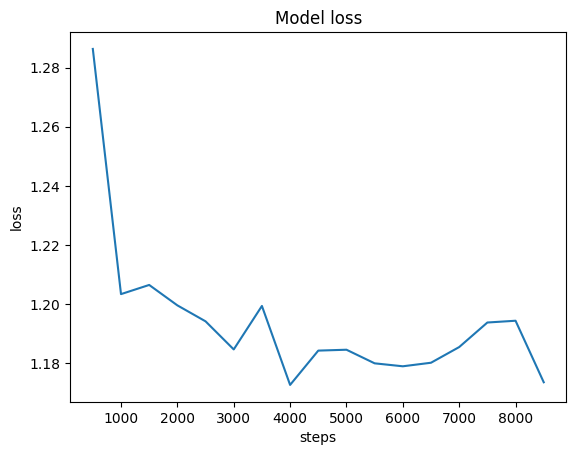

In [25]:
import matplotlib.pyplot as plt

plt.plot(steps, train_loss)
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('steps')
plt.show()

In [26]:
trainer.push_to_hub()

'https://huggingface.co/anujsahani01/PyLoomer_CodeGen/tree/main/'

In [27]:
from transformers import AutoModelForCausalLM, pipeline

model_ckpt = "anujsahani01/PyLoomer_CodeGen"
model = AutoModelForCausalLM.from_pretrained(model_ckpt)

In [28]:
model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50300. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(50300, 1024)

In [29]:
tokenizer = AutoTokenizer.from_pretrained("anujsahani01/PyLoomer_CodeGen",
                                          vocab_size = len(tokenizer),
                                          additional_special_tokens = ["<SYSTEM_TASK:>", "<USER_TASK:>", "<ASSISTANT_TASK:>", "<END_TASK>"],
                                          pad_token = "<PAD>",
                                          model_max_length = 3000
                                          )

print(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


CodeGenTokenizerFast(name_or_path='anujsahani01/PyLoomer_CodeGen', vocab_size=50257, model_max_length=3000, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<PAD>', 'additional_special_tokens': ['<SYSTEM_TASK:>', '<USER_TASK:>', '<ASSISTANT_TASK:>', '<END_TASK>']}, clean_up_tokenization_spaces=True)


In [30]:
add_prompt = '<SYSTEM_TASK:>\nGiven the following code description, write Python code to implement the functionality described below\n<END_TASK>\n<USER_TASK:>\nDescription:\n'
text_prompt = 'def VGG16_model_architecture()\n"""\nInitialize VGG16 model a deep learning model trained on imagenet for performing Image Classification in the VGG16_model_architecture function\n"""\n\bdef train_test_split():\n\t"""Split the data X, Y in to train and test data using sklearn"""\n\bdef model_predict():\n\t"""Make prediction using the deep learning model defined above in VGG16_model_architecture function"""\n'

final_prompt = add_prompt + text_prompt

In [31]:
# pad_token_id = tokenizer.pad_token_id

In [32]:
pipe = pipeline('text-generation', model = model_ckpt)
print(pipe(final_prompt, num_return_sequences=1, max_new_tokens = 150)[0]['generated_text'])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<SYSTEM_TASK:>
Given the following code description, write Python code to implement the functionality described below
<END_TASK>
<USER_TASK:>
Description:
def VGG16_model_architecture()
"""
Initialize VGG16 model a deep learning model trained on imagenet for performing Image Classification in the VGG16_model_architecture function
"""
def train_test_split():
	"""Split the data X, Y in to train and test data using sklearn"""
def model_predict():
	"""Make prediction using the deep learning model defined above in VGG16_model_architecture function"""
	X = X.reshape(len(X),-1)
	y_predict = []
	for example_length in X:
		rand = np.random.rand(example_length)
		rand = rand * 1/len(X)
		y_predict.append(vgg16_model_architecture.predict").argmax(1)
	y_train = list(map(lambda x, y: 1 if x in y_predict else 0, X, Y))
	y_train = np.asarray(y_train)
	print("X_train, y_train:",X.shape, y_train


In [39]:
from transformers import GenerationConfig
inputs = tokenizer(final_prompt, return_tensors = 'pt')
generation_config = GenerationConfig(max_new_tokens=500, temperature= 0.89, do_sample=True, top_p = 5)

output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens = 500,
        generation_config=generation_config,
        pad_token_id = tokenizer.pad_token_id,
    )[0],
    skip_special_tokens=True
)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{final_prompt}')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')

---------------------------------------------------------------------------------------------------
INPUT PROMPT:
<SYSTEM_TASK:>
Given the following code description, write Python code to implement the functionality described below
<END_TASK>
<USER_TASK:>
Description:
def VGG16_model_architecture()
"""
Initialize VGG16 model a deep learning model trained on imagenet for performing Image Classification in the VGG16_model_architecture function
"""
def train_test_split():
	"""Split the data X, Y in to train and test data using sklearn"""
def model_predict():
	"""Make prediction using the deep learning model defined above in VGG16_model_architecture function"""

---------------------------------------------------------------------------------------------------
MODEL GENERATION - ZERO SHOT:

Given the following code description, write Python code to implement the functionality described below


Description:
def VGG16_model_architecture()
"""
Initialize VGG16 model a deep learning model tr

In [34]:
! pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24932 sha256=4a9a5e3222f2dc9420e992ac67d1fb1ed500edce246d7404e93834184b38d9c3
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [35]:
rouge = evaluate.load('rouge')

In [36]:
model.config.pad_token_id = tokenizer.pad_token_id = tokenizer.unk_token_id

In [42]:
prompts = dataset['test'][0:10]['text_prompt']
human_baseline_codes = dataset['test'][0:10]['code_prompt']

finetuned_model_codes = []
generation_config = GenerationConfig(max_new_tokens=200, temperature= 0.5, do_sample=True, top_p = 5)

for _, prompt in enumerate(prompts):
    prompt = f"""
'<SYSTEM_TASK:>\nSolve the following problem using Python, implementing the functions described below, one line at a time\n<END_TASK>\n<USER_TASK:>\nDescription:\n'
{prompt}
"""
    input = tokenizer(prompt, return_tensors="pt")
    finetuned_model_outputs = model.generate(input['input_ids'], generation_config=generation_config ,  pad_token_id = tokenizer.pad_token_id)
    finetuned_model_text_output = tokenizer.decode(finetuned_model_outputs[0], skip_special_tokens=True)
    finetuned_model_codes.append(finetuned_model_text_output)

zipped_summaries = list(zip(human_baseline_codes, finetuned_model_codes))
df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_codes', 'finetuned_model_codes'])
df

human_baseline_codes  \
0  \n        self._log('get user orders')\n      ...   
1  \n        self._log('get user trades')\n      ...   
2  \n        amount = str(amount)\n        self._...   
3  \n        amount = str(amount)\n        price ...   
4  \n        # if the user has not logged in in 2...   
5  \n        login_return = self._is_logged_in()\...   
6  \n        login_return = self._is_logged_in()\...   
7  \n        kwargs['key']="requestPosition"\n   ...   
8  \n        try:\n            return hv.NdLayout...   
9  \n        try:\n            return hv.Layout(c...   

                               finetuned_model_codes  
0  \n'\nSolve the following problem using Python,...  
1  \n'\nSolve the following problem using Python,...  
2  \n'\nSolve the following problem using Python,...  
3  \n'\nSolve the following problem using Python,...  
4  \n'\nSolve the following problem using Python,...  
5  \n'\nSolve the following problem using Python,...  
6  \n'\nSolve the following problem using Python,...  
7  \n'\nSolve the following problem using Python,...  
8  \n'\nSolve the following problem using Python,...  
9  \n'\nSolve the following problem using Python,...

In [43]:
finetuned_model_results = rouge.compute(
    predictions=finetuned_model_codes,
    references=human_baseline_codes[0:len(finetuned_model_codes)],
    use_aggregator=True,
    use_stemmer=True,
)

print(finetuned_model_results)

{'rouge1': 0.19187954900080972, 'rouge2': 0.05040525228495025, 'rougeL': 0.1285343604827428, 'rougeLsum': 0.18347857402872228}


# **Certainly, let's calculate the overall best score by taking the average of the individual Rouge scores (Rouge-1, Rouge-2, Rouge-L, and Rouge-Lsum) for both the original model and the fine-tuned model:**

**Original Model Average Rouge Score**:

(0.1852 + 0.0443 + 0.1272 + 0.1773) / 4 = 0.1335


**Fine-tuned Model Average Rouge Score:**

(0.1919 + 0.0504 + 0.1285 + 0.1835) / 4 = 0.1386

Comparing the average Rouge scores, the fine-tuned model has a slightly higher overall average Rouge score (0.1386) compared to the original model (0.1335). Therefore, the fine-tuned model is the overall best performer based on the Rouge scores.